# Mise en place du notebook

## Versionning

P6 v7 : avant split entre "P6 part1 v01" (contient la récupération des données et le SIFT) et "P6 part2 v01" (contient VGG-16).  
P6 part2 : début VGG-16.

## Import des modules

In [1]:
# imports pour le développement
from pympler import asizeof
import mesfonctions
from importlib import reload
mesfonctions = reload(mesfonctions)

# imports pour la production
import warnings
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rcParams
from cycler import cycler
from dataprep.eda import create_report
from sklearn import decomposition
from sklearn import cluster, manifold, decomposition, preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AffinityPropagation, MeanShift, Birch
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, rand_score, confusion_matrix, accuracy_score
from mesfonctions import display_scree_plot, display_factorial_planes, draw_tsne, draw_umap, accuracy_svm
import pickle
from termcolor import colored, cprint
import cv2
from yellowbrick.cluster import KElbowVisualizer
import random
from collections import Counter
import disarray
import collections

NumExpr defaulting to 8 threads.


## Fonctions courantes

In [2]:
def nom_fichier_photo(index, df=None):
    """Retourne le chemin + nom du fichier jpg d'une ligne de dataframe.
    Args : 
    - index : index de la ligne de df.
    Returns :
    - string.
    """
    if df is None:
        df = df_source
    return PATH + df['image'][index]

## Constantes

In [3]:
PATH = "Images_Flipkart/"

## Gestion des paramètres d'affichage de Jupyter

In [4]:
plt.style.use('seaborn')

warnings.filterwarnings(category=FutureWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# Chargement du dataframe

In [5]:
df_source = pickle.load(open('df_source.pkl', 'rb'))
df_source

uniq_id                           crawl_timestamp             \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

     product_url                                         \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

     product_name                                        \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

     product_category_tree                              pid                \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price image                                  \
0     1899.0         899.0            55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0         449.0            7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        NaN           NaN            64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     2699.0        1299.0            d4684dcdc759dd9cdf41504698d737d8.jpg   
4     2599.0         698.0            6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045  1399.0         999.0            958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  4930.0        1896.0            fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  4500.0        1449.0            5912e037d12774bb73a2048f35a00009.jpg   
1048  3465.0        1333.0            c3edc504d1b4f0b

In [6]:
labels = ["Beauty and Personal Care", "Computers", "Baby Care", "Home Decor", "Home Furnishing", "Kitchen & Dining", "Watches"]

# VGG-16

## Feature extraction

On déroule cette méthodologie :  
    https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/  
Chapitre : Pre-Trained Model as Feature Extractor Preprocessor  

In [7]:
# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [8]:
def VGG16_extracteur(nom_image='cat.jpg'):
    # load an image from file
    image = load_img(nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    im_features = model.predict(image)
    return im_features
    
# test unitaire
VGG16_extracteur()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
list_features = []
for i in range(len(df_source)):
    if i%10 == 0 : print(i, "", end='')
    nom_image = nom_fichier_photo(i)
    list_features.append(VGG16_extracteur(nom_image))

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 

In [38]:
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(list_features, open('list_features_VGG16.pkl', 'wb'))

In [9]:
# Chargement des descripteurs calculés (pickle)
list_features = pickle.load(open('list_features_VGG16.pkl', 'rb'))

In [10]:
arr_features = np.asarray(list_features)
display (arr_features)

array([[[3.3986144 , 0.8595722 , 0.        , ..., 0.        , 0.8510551 , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 1.2970998 , 0.        , 0.        ]],

       ...,

       [[2.1961298 , 2.3982751 , 2.6236405 , ..., 2.159872  , 0.18472159, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        , 0.24833043, 0.9251383 ]],

       [[0.        , 0.        , 0.1231316 , ..., 0.        , 0.5277166 , 2.9917495 ]]], dtype=float32)

In [11]:
arr_features = np.concatenate(arr_features, axis=0)
display (arr_features)

array([[3.3986144 , 0.8595722 , 0.        , ..., 0.        , 0.8510551 , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 1.2970998 , 0.        , 0.        ],
       ...,
       [2.1961298 , 2.3982751 , 2.6236405 , ..., 2.159872  , 0.18472159, 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24833043, 0.9251383 ],
       [0.        , 0.        , 0.1231316 , ..., 0.        , 0.5277166 , 2.9917495 ]], dtype=float32)

In [12]:
arr_features.shape

(1050, 4096)

## Réduction de dimension

### Réduction de dimension PCA

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 850)


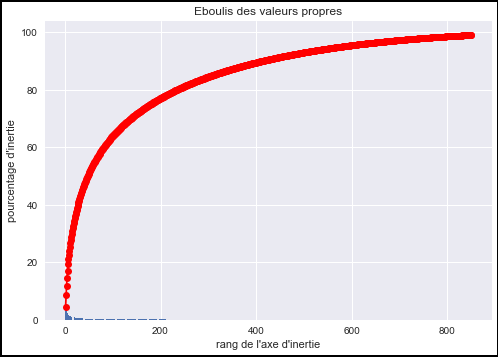

In [13]:
print("Dimensions dataset avant réduction PCA : ", arr_features.shape)
pca = decomposition.PCA(n_components=0.99)
arr_features_scaled = preprocessing.StandardScaler().fit_transform(arr_features)   # données centrées réduites
# arr_features_scaled = arr_features
feat_pca= pca.fit_transform(arr_features_scaled)
# feat_pca = arr_features_scaled
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

### Visualisation par t-SNE

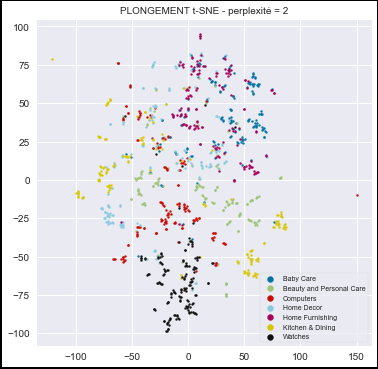

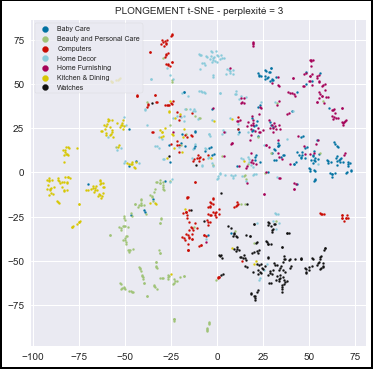

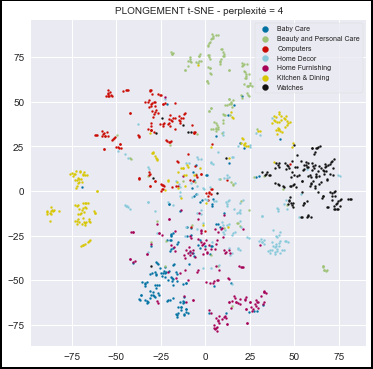

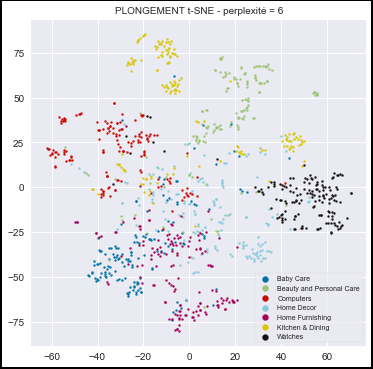

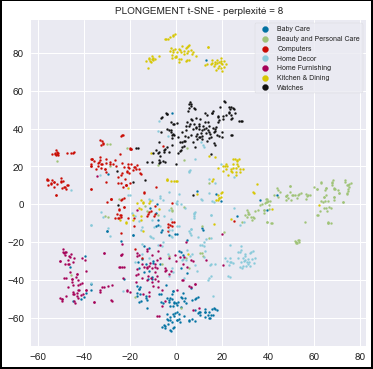

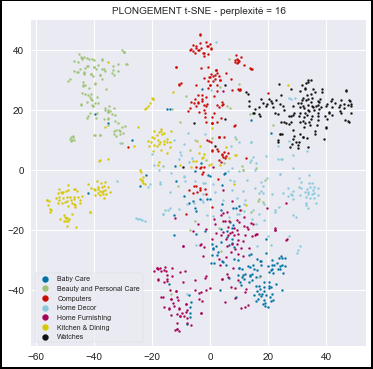

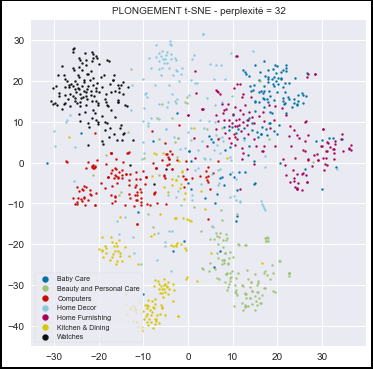

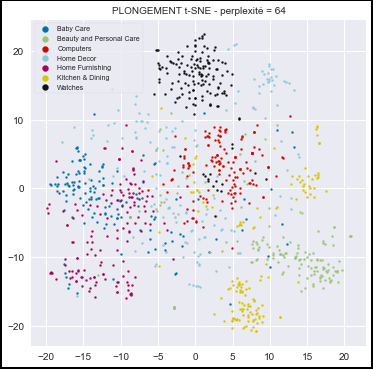

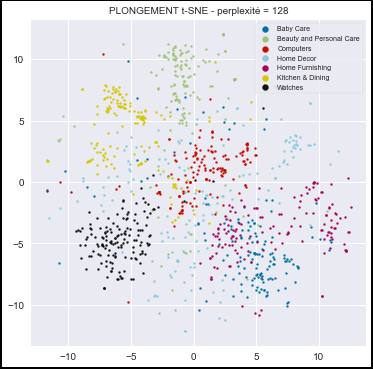

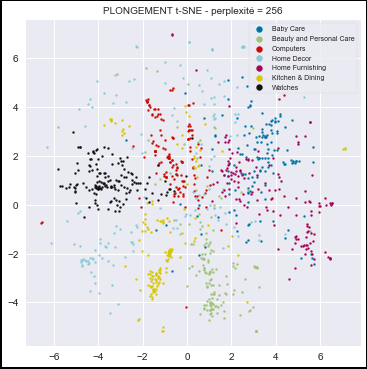

In [14]:
perplexities = [2, 3, 4, 6, 8, 16, 32, 64, 128, 256]
draw_tsne(feat_pca, perplexities, df_source['label'])

In [ ]:
perplexities = range(16,33,2)
draw_tsne(feat_pca, perplexities, df_source['label'])

### Visualisation par UMAP

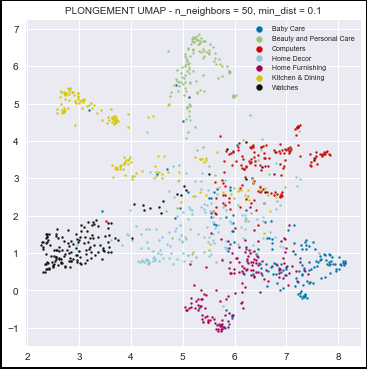

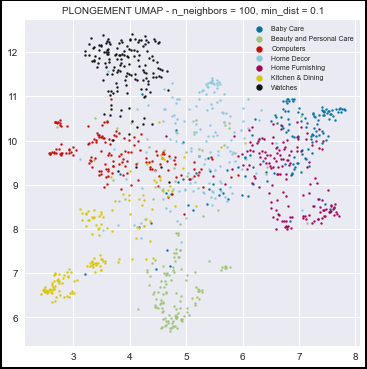

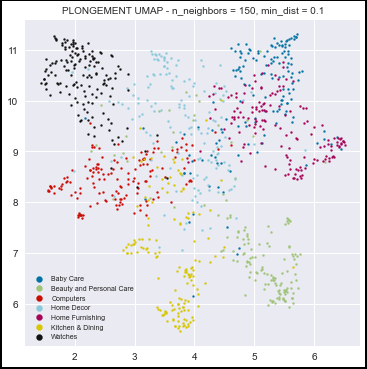

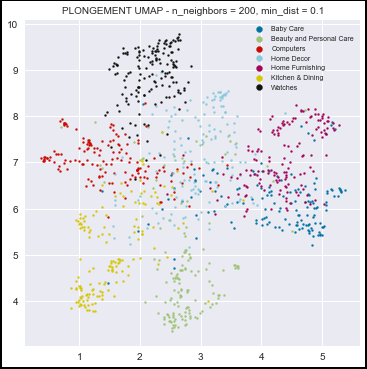

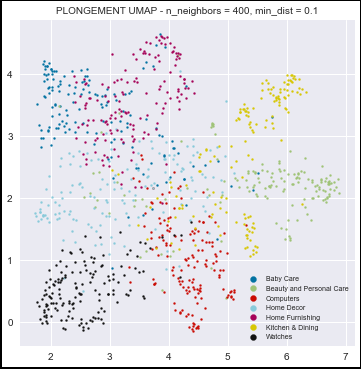

In [15]:
plt.style.use('seaborn')
for n_neighbors in (50, 100, 150, 200, 400):
    draw_umap(feat_pca, df_source['label'], n_neighbors)

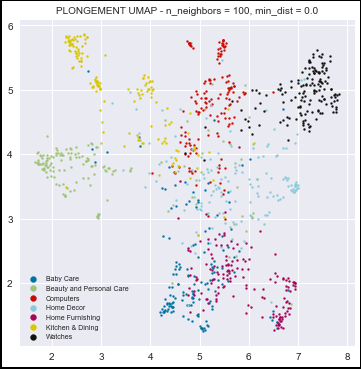

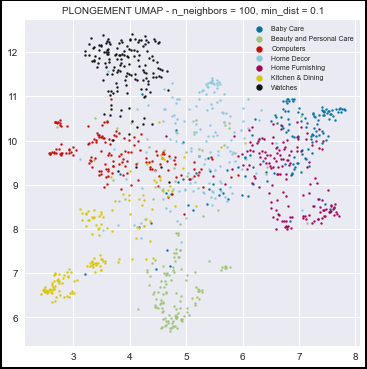

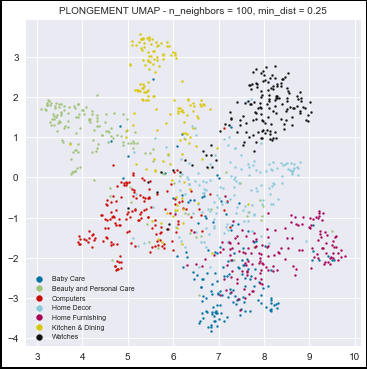

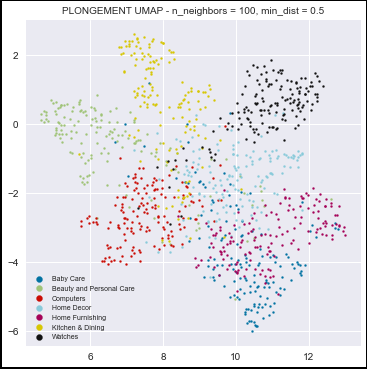

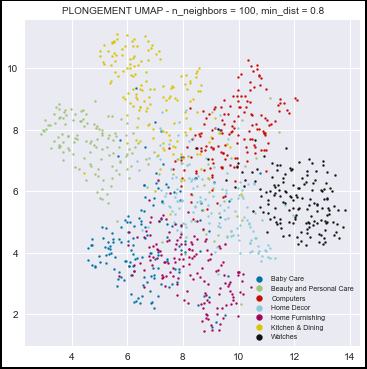

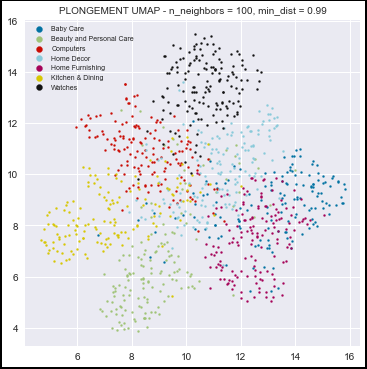

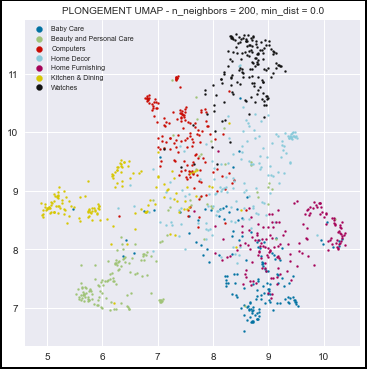

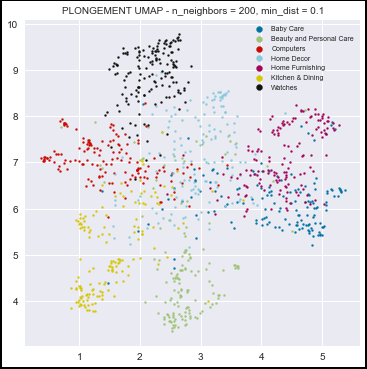

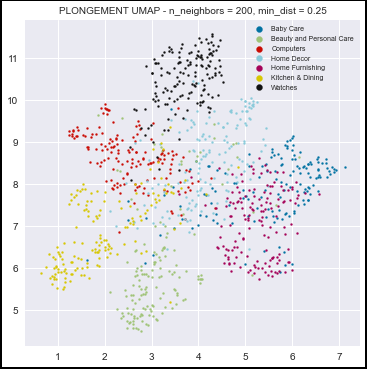

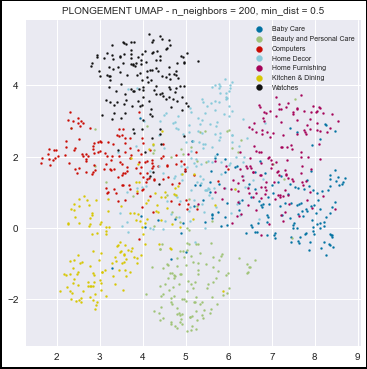

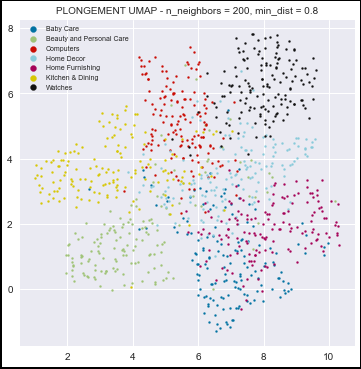

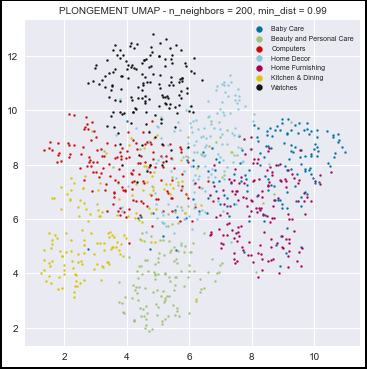

In [16]:
for n_neighbors in (100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
        draw_umap(feat_pca, df_source['label'], n_neighbors, min_dist)

## Clustering par k-means

### Méthode du coude sur l'inertie pour déterminer le k optimum

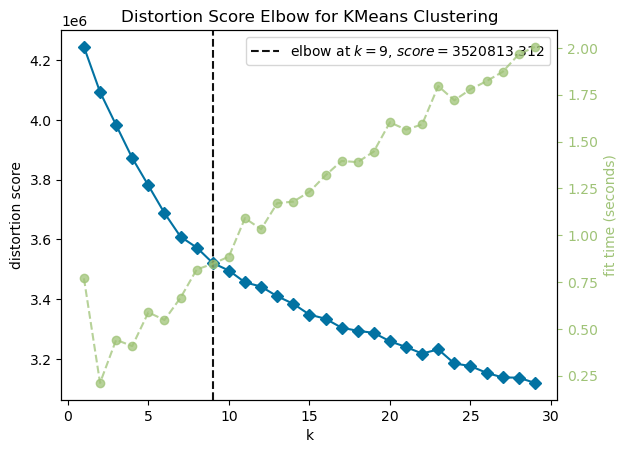

In [49]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))

visualizer.fit(feat_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

### Score de silhouette pour déterminer le k optimum

In [17]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(feat_pca)
                for k in range(1, 15)]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


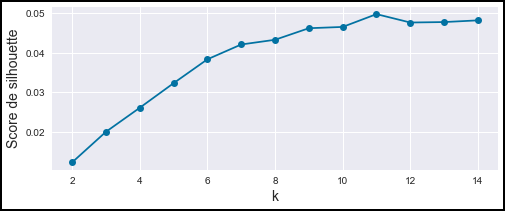

In [18]:
silhouette_scores = [silhouette_score(feat_pca, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Score de silhouette", fontsize=14)
plt.show()

### Diagrammes de silhouette

In [19]:
def diagramme_silhouette(data_scaled, kmeans_per_k):
    """ Affichage du diagramme de silhouette
    Args : 
    - kmeans_per_k : liste des modélisations pour k=1 (oui, k=1) à k=k_max.
    - data_scaled : dataframe pandas converti, centré et normalisé.
    Returns :
    - tracés matplotlib (pour k=2 à k=k_max).
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(11, 13), edgecolor='black', linewidth=4)
    
    silhouette_scores = [silhouette_score(data_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

    for k in range(2, 11):
        plt.subplot(3, 3, k - 1)

        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(data_scaled,
                                                     y_pred)

        padding = len(data_scaled) // 30
        pos = padding
        ticks = []

        # on trie les clusters du plus petit au plus grand
        taille_clusters = {}
        for i in range(k):
            taille_clusters[i] = len(silhouette_coefficients[y_pred == i])
        taille_clusters = {
            k: v
            for k, v in sorted(taille_clusters.items(),
                               key=lambda item: item[1])
        }
        i_color = 0
        for i in reversed(taille_clusters.keys()):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            color = mpl.cm.Spectral(i_color / (k - 1))
            i_color += 1
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)),
                              0,
                              coeffs,
                              facecolor=color,
                              edgecolor=color,
                              alpha=1)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(
            FixedFormatter(list(reversed(taille_clusters.keys()))))
        if k in (2, 5, 8):
            plt.ylabel("Cluster")
        plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if k in (8, 9, 10):
            plt.xlabel("Coefficient de silhouette")
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=14)

    plt.show()

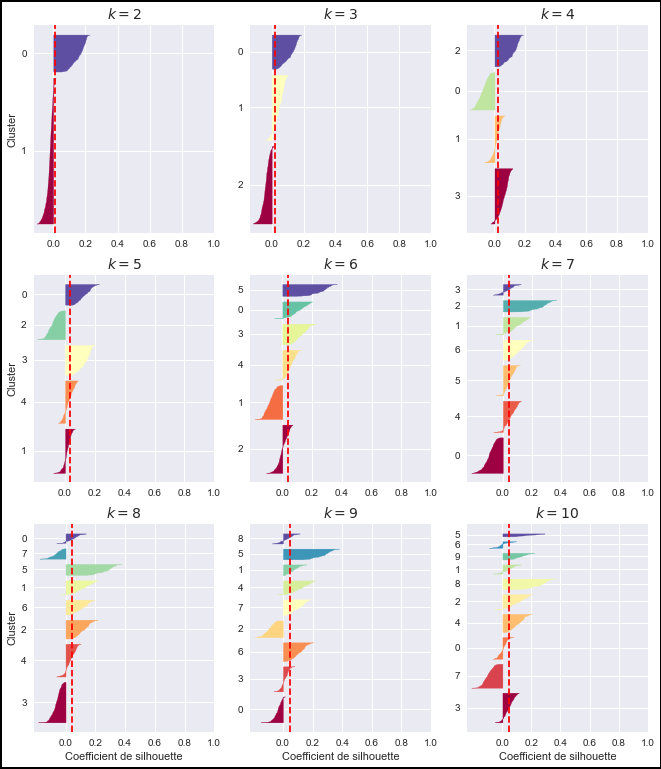

In [20]:
diagramme_silhouette(feat_pca, kmeans_per_k)

### Adjusted Rand Score pour les 7 catégories labellisées

#### Conditions standard de PCA (99% d'inertie)

In [21]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
cprint(f"ARI : {adjusted_rand_score(df_source['label'], model.labels_)}", 'red')

ARI : 0.4955182634860406


#### Résultats issus de modifications de l'étape de PCA

###### Sans StandardScaler

On omet le StandardScaler avant la PCA.  
C'est globalement un peu meilleur avec StandardScaler.  
Note : 803 dimensions (vs 850) avec PCA à 99% d'inertie.  

In [190]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4768143608291434


###### Sans PCA (et avec StandardScaler)

4096 dimensions

In [216]:
model = KMeans(n_clusters=7, random_state=0, n_init=20000).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49272122875957286


###### PCA à 95% d'inertie

581 dimensions post PCA  

In [186]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49752548907902355


###### PCA à 90% d'inertie

414 dimensions post PCA  

In [184]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4915546841879664


###### PCA à 80% d'inertie

235 dimensions post PCA  

In [194]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4965216221037307


###### PCA à 60% d'inertie

82 dimensions post PCA  

In [197]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.4924223368835112


###### PCA à 40% d'inertie

27 dimensions post PCA  

In [199]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.49312135421548947


###### PCA à 20% d'inertie

7 dimensions post PCA  

In [201]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.5159241544434252


###### PCA => 3 dimensions

In [208]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.46549647321688403


###### PCA => 2 dimensions

In [210]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.347854499444082


###### PCA => 1 dimension

In [212]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))

ARI : 0.20887099064066397


### Comparaison graphique entre les valeurs "true" et le partitionnement proposé par le k-means

#### k-means 7 clusters

In [22]:
model = kmeans_per_k[6]
model

KMeans(n_clusters=7, random_state=0)

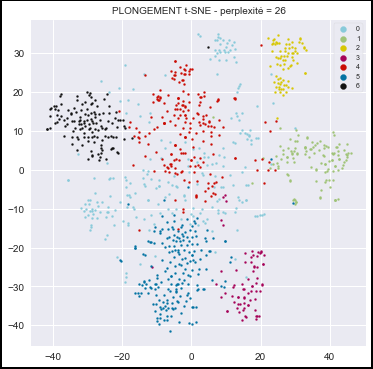

In [23]:
plt.style.use('seaborn')
draw_tsne(feat_pca, [26], model.labels_, 'cgymrbk')

#### Pour rappel, les labels "true"

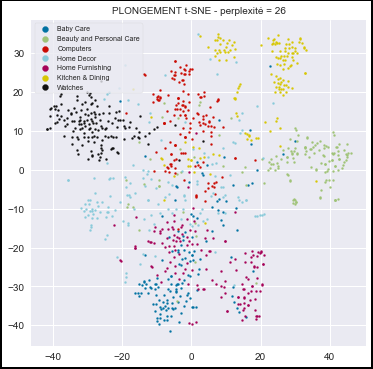

In [24]:
draw_tsne(feat_pca, [26], df_source['label'])

#### Matrice de confusion

In [26]:
conf_mat = confusion_matrix(df_source['int_label'], model.labels_)
df_conf = pd.DataFrame(conf_mat, columns=range(7), index=labels)
display(df_conf)

0    1    2   3   4    5    6  
Beauty and Personal Care   15  109   0   1   18    7    0
Computers                   5    1   0   0  144    0    0
Baby Care                  22    3   1  10    5  109    0
Home Decor                135    1   0   3    7    2    2
Home Furnishing             7    0   0  58    1   84    0
Kitchen & Dining           51    3  76   0   18    1    1
Watches                     3    0   0   0   16    0  131

In [27]:
corresp = np.argmax(conf_mat, axis=1)
corresp

array([1, 4, 5, 0, 5, 2, 6], dtype=int64)

In [28]:
len(np.unique(corresp))

6

In [29]:
# matrice de confusion réorganisée avec les true positives sur la diagonale
df_conf = df_conf[[1, 4, 5, 0, 3, 2, 6]]
df_conf

1    4    5    0    3   2   6  
Beauty and Personal Care  109   18    7   15   1   0    0
Computers                   1  144    0    5   0   0    0
Baby Care                   3    5  109   22  10   1    0
Home Decor                  1    7    2  135   3   0    2
Home Furnishing             0    1   84    7  58   0    0
Kitchen & Dining            3   18    1   51   0  76    1
Watches                     0   16    0    3   0   0  131

In [30]:
df_conf.columns=labels
df_conf

Beauty and Personal Care  Computers  Baby Care  \
Beauty and Personal Care  109                        18          7         
Computers                   1                       144          0         
Baby Care                   3                         5        109         
Home Decor                  1                         7          2         
Home Furnishing             0                         1         84         
Kitchen & Dining            3                        18          1         
Watches                     0                        16          0         

                          Home Decor  Home Furnishing  Kitchen & Dining  \
Beauty and Personal Care   15          1                0                 
Computers                   5          0                0                 
Baby Care                  22         10                1                 
Home Decor                135          3                0                 
Home Furnishing             7         58                0                 
Kitchen & Dining           51          0               76                 
Watches                     3          0                0                 

                          Watches  
Beauty and Personal Care    0      
Computers                   0      
Baby Care                   0      
Home Decor                  2      
Home Furnishing             0      
Kitchen & Dining            1      
Watches                   131

In [31]:
df_conf.astype('int32').da.export_metrics(['accuracy', 'precision', 'recall', 'f1', 'specificity']).drop(columns=['micro-average'])

Beauty and Personal Care  Computers  Baby Care  Home Decor  \
accuracy     0.953333                  0.932381   0.871429   0.887619     
precision    0.931624                  0.688995   0.536946   0.567227     
recall       0.726667                  0.960000   0.726667   0.900000     
f1           0.816479                  0.802228   0.617564   0.695876     
specificity  0.991111                  0.927778   0.895556   0.885556     

             Home Furnishing  Kitchen & Dining  Watches   
accuracy     0.899048         0.928571          0.979048  
precision    0.805556         0.987013          0.977612  
recall       0.386667         0.506667          0.873333  
f1           0.522523         0.669604          0.922535  
specificity  0.984444         0.998889          0.996667

#### Accuracy (exactitude) globale après attribution manuelle des labels

In [32]:
model.labels_ 

array([3, 5, 5, ..., 3, 0, 0])

In [33]:
arr_0 = (model.labels_ == 0)
arr_1 = (model.labels_ == 1)
arr_2 = (model.labels_ == 2)
arr_3 = (model.labels_ == 3)
arr_4 = (model.labels_ == 4)
arr_5 = (model.labels_ == 5)
arr_6 = (model.labels_ == 6)

# [1, 4, 5, 0, 3, 2, 6]
labels_reattribues = 0*arr_1 + 1*arr_4 + 2*arr_5 + 3*arr_0 + 4*arr_3 + 5*arr_2 + 6*arr_6
labels_reattribues

array([4, 2, 2, ..., 4, 3, 3])

In [34]:
print("accuracy_score : %.2f" % accuracy_score(df_source['int_label'], labels_reattribues))

accuracy_score : 0.73


Note : on retrouve bien cette valeur en divisant la somme de la diagonale de la matrice de confusion par 1050.

## Clustering par DBSCAN

In [35]:
clustering = DBSCAN(eps=0.01, min_samples=2).fit(feat_pca)

In [36]:
label_list = np.unique(clustering.labels_)
label_list

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [37]:
collections.Counter(clustering.labels_)

Counter({-1: 1028, 0: 3, 1: 7, 2: 3, 3: 2, 4: 4, 5: 3})

DBSCAN ne parvient pas à former des clusters. Il ne trouve que des noisy samples (label -1).

## Classification ascendante hiérarchique

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata

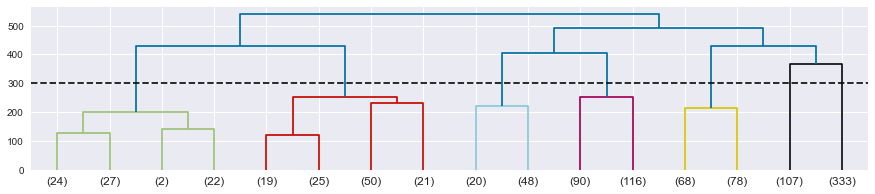

In [39]:
linkage_matrix = linkage(feat_pca, method='ward')
plt.figure(figsize=(15, 3), edgecolor='black')
plt.axhline(300, c='k', linestyle='--')
_ = dendrogram(linkage_matrix, orientation='top', p=3, truncate_mode='level')

Il y a sept clusters apparents. Mais les distributions ne correspondent absolument pas aux effectifs des tru_labels.  

### Adjusted Rand Score pour les 7 catégories labellisées

In [50]:
labels_ = fclusterdata(feat_pca, t=7, criterion='maxclust', method='ward')
labels_ -= 1  # fclusterdata retourne des labels qui s'incrémentent à partir de 1 (on veut un incrément depuis 0)
labels_

array([2, 3, 3, ..., 6, 6, 3], dtype=int32)

In [51]:
cprint(f"ARI : {adjusted_rand_score(df_source['label'], labels_)}", 'red')

ARI : 0.44953923242022115


### Matrice de confusion

In [52]:
conf_mat = confusion_matrix(df_source['int_label'], labels_)
conf_mat

array([[  0, 113,   1,   6,   2,   4,  24],
       [  0,   0,   0,   1,   1,  99,  49],
       [  1,   1,   6, 112,   0,   1,  29],
       [  0,   0,   0,   9,   0,   0, 141],
       [  0,   0,  61,  76,   0,   0,  13],
       [ 74,   1,   0,   2,   1,   1,  71],
       [  0,   0,   0,   0, 142,   2,   6]], dtype=int64)

In [53]:
df_conf = pd.DataFrame(conf_mat, columns=range(7), index=labels)
display(df_conf)

0   1    2   3    4    5   6  
Beauty and Personal Care   0  113   1    6    2   4   24
Computers                  0    0   0    1    1  99   49
Baby Care                  1    1   6  112    0   1   29
Home Decor                 0    0   0    9    0   0  141
Home Furnishing            0    0  61   76    0   0   13
Kitchen & Dining          74    1   0    2    1   1   71
Watches                    0    0   0    0  142   2    6

In [54]:
corresp = np.argmax(conf_mat, axis=1)
corresp

array([1, 5, 3, 6, 3, 0, 4], dtype=int64)

In [55]:
len(np.unique(corresp))

6

In [56]:
# matrice de confusion réorganisée avec les true positives sur la diagonale
df_conf = df_conf[[1, 5, 3, 6, 2, 0, 4]]
df_conf

1    5   3    6    2   0   4  
Beauty and Personal Care  113   4    6   24   1   0    2
Computers                   0  99    1   49   0   0    1
Baby Care                   1   1  112   29   6   1    0
Home Decor                  0   0    9  141   0   0    0
Home Furnishing             0   0   76   13  61   0    0
Kitchen & Dining            1   1    2   71   0  74    1
Watches                     0   2    0    6   0   0  142

In [57]:
df_conf.columns=labels
df_conf

Beauty and Personal Care  Computers  Baby Care  \
Beauty and Personal Care  113                        4           6         
Computers                   0                       99           1         
Baby Care                   1                        1         112         
Home Decor                  0                        0           9         
Home Furnishing             0                        0          76         
Kitchen & Dining            1                        1           2         
Watches                     0                        2           0         

                          Home Decor  Home Furnishing  Kitchen & Dining  \
Beauty and Personal Care   24          1                0                 
Computers                  49          0                0                 
Baby Care                  29          6                1                 
Home Decor                141          0                0                 
Home Furnishing            13         61                0                 
Kitchen & Dining           71          0               74                 
Watches                     6          0                0                 

                          Watches  
Beauty and Personal Care    2      
Computers                   1      
Baby Care                   0      
Home Decor                  0      
Home Furnishing             0      
Kitchen & Dining            1      
Watches                   142

In [58]:
df_conf.astype('int32').da.export_metrics(['accuracy', 'precision', 'recall', 'f1', 'specificity'])

Beauty and Personal Care  Computers  Baby Care  Home Decor  \
accuracy     0.962857                  0.943810   0.874286   0.808571     
precision    0.982609                  0.925234   0.543689   0.423423     
recall       0.753333                  0.660000   0.746667   0.940000     
f1           0.852830                  0.770428   0.629213   0.583851     
specificity  0.997778                  0.991111   0.895556   0.786667     

             Home Furnishing  Kitchen & Dining  Watches   micro-average  
accuracy     0.908571         0.926667          0.988571  0.916190       
precision    0.897059         0.986667          0.972603  0.706667       
recall       0.406667         0.493333          0.946667  0.706667       
f1           0.559633         0.657778          0.959459  0.706667       
specificity  0.992222         0.998889          0.995556  0.951111

## Clustering par Affinity Propagation

In [59]:
model = AffinityPropagation(random_state=0, max_iter=10000, preference=-80000)
model.fit(feat_pca)

AffinityPropagation(max_iter=10000, preference=-80000, random_state=0)

In [60]:
model.n_iter_

43

In [61]:
labels_ = model.labels_
print("Nb de clusters :", len(np.unique(labels_)))
print("Effectifs des clusters :")
bincounts = np.bincount(labels_)
print(bincounts)
print("Fréquences :")
print([round(bincount / sum(bincounts) * 100 * 10) / 10 for bincount in bincounts])

Nb de clusters : 7
Effectifs des clusters :
[170 131  79 171 237  50 212]
Fréquences :
[16.2, 12.5, 7.5, 16.3, 22.6, 4.8, 20.2]


### Adjusted Rand Score pour les 7 catégories labellisées

In [62]:
cprint("ARI : {:.2f}".format(adjusted_rand_score(df_source['label'], labels_)), 'red')

ARI : 0.33


## Clustering par Mean Shift

In [364]:
model = MeanShift(bandwidth=2)
model.fit(feat_pca)

MeanShift(bandwidth=2)

In [365]:
model.n_iter_

0

In [366]:
labels_ = model.labels_
print("Nb de clusters :", len(np.unique(labels_)))
print("Effectifs des clusters :")
bincounts = np.bincount(labels_)
print(bincounts)
print("Fréquences :")
print([round(bincount / sum(bincounts) * 100 * 10) / 10 for bincount in bincounts])

Nb de clusters : 1034
Effectifs des clusters :
[7 4 3 ... 1 1 1]
Fréquences :
[0.7, 0.4, 0.3, 0.3, 0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

Avec nos données, impossible de trouver un plus faible nb de clusters.

## Clustering par BIRCH

In [63]:
model = Birch(n_clusters=7)
model.fit(feat_pca)

Birch(n_clusters=7)

In [64]:
labels_ = model.labels_
print("Nb de clusters :", len(np.unique(labels_)))
print("Effectifs des clusters :")
bincounts = np.bincount(labels_)
print(bincounts)
print("Fréquences :")
print([round(bincount / sum(bincounts) * 100 * 10) / 10 for bincount in bincounts])

Nb de clusters : 7
Effectifs des clusters :
[346 115 114 206  75  48 146]
Fréquences :
[33.0, 11.0, 10.9, 19.6, 7.1, 4.6, 13.9]


### Adjusted Rand Score pour les 7 catégories labellisées

In [65]:
cprint("ARI : {:.2f}".format(adjusted_rand_score(df_source['label'], labels_)), 'red')

ARI : 0.43


## Classification par SVM

In [66]:
accuracy_svm(feat_pca, df_source['int_label'], n_run=100)

Accuracy : moyenne = 0.835, écart-type = 0.018
